In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import pandas as pd
import os
from scipy.interpolate import CubicSpline

In [2]:
Ts = 0.001

theta_zero = np.pi / 4
magnitude_zero = -0.3
a0 = magnitude_zero * np.exp(1j * theta_zero)
a1 = magnitude_zero * np.exp(-1j * theta_zero)

theta_pole = np.pi / 2
magnitude_pole = 0.8
b0 = magnitude_pole * np.exp(1j * theta_pole)  # 極點
b1 = magnitude_pole * np.exp(-1j * theta_pole) # 極點

# H(z)
num = np.polymul([1, -a0], [1, -a1]).real  
print(num)
den = np.polymul([1, -b0], [1, -b1])
den = np.real_if_close(den)

H_z = ctrl.TransferFunction(num, den, Ts)
print(H_z)

[1.         0.42426407 0.09      ]

 z^2 + 0.4243 z + 0.09
------------------------
z^2 - 9.797e-17 z + 0.64

dt = 0.001



In [3]:
Ts = 0.001

# 原本的零點
theta_zero1 = np.pi / 4
magnitude_zero1 = -0.5
a0 = magnitude_zero1 * np.exp(1j * theta_zero1)
a1 = magnitude_zero1 * np.exp(-1j * theta_zero1)

# 新增的零點
theta_zero2 = np.pi / 3  # 另一個角度
magnitude_zero2 = 0.6
a2 = magnitude_zero2 * np.exp(1j * theta_zero2)
a3 = magnitude_zero2 * np.exp(-1j * theta_zero2)

# 原本的極點
theta_pole1 = np.pi / 2
magnitude_pole1 = 0.8
b0 = magnitude_pole1 * np.exp(1j * theta_pole1)
b1 = magnitude_pole1 * np.exp(-1j * theta_pole1)

# 新增的極點
theta_pole2 = np.pi / 4
magnitude_pole2 = 0.7
b2 = magnitude_pole2 * np.exp(1j * theta_pole2)
b3 = magnitude_pole2 * np.exp(-1j * theta_pole2)

# 計算分子（零點）和分母（極點）的多項式
num = np.polymul(np.polymul([1, -a0], [1, -a1]), np.polymul([1, -a2], [1, -a3])).real
den = np.polymul(np.polymul([1, -b0], [1, -b1]), np.polymul([1, -b2], [1, -b3]))
den = np.real_if_close(den)

# 創建 H(z) 轉移函數
H_z = ctrl.TransferFunction(num, den, Ts)
print(H_z)


z^4 + 0.1071 z^3 + 0.1857 z^2 + 0.1046 z + 0.09
-----------------------------------------------
z^4 - 0.9899 z^3 + 1.13 z^2 - 0.6336 z + 0.3136

dt = 0.001




5 z^5 + 5.535 z^4 + 1.464 z^3 + 1.451 z^2 + 0.9728 z + 0.45
------------------------------------------------------------
6 z^5 + 3.546 z^4 + 3.584 z^3 - 0.3121 z^2 + 1.92 z + 0.1364

dt = 0.001



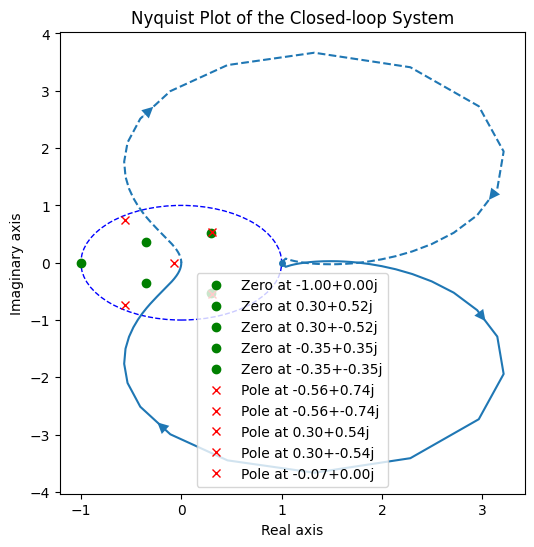

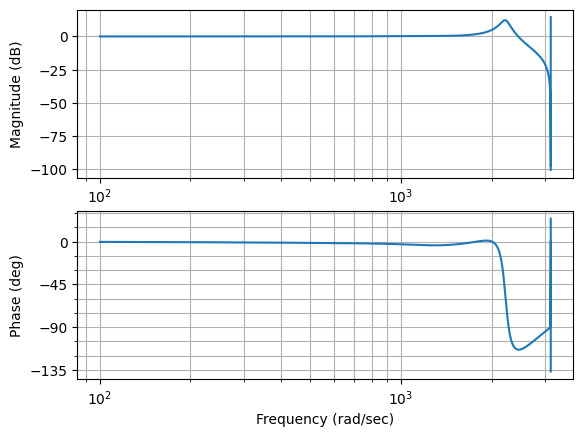

In [4]:

# ---------- PID  ----------=
Kp = 5
Ki = 0.1
Kd = 0   

# 只有 P 控制器
C_z = ctrl.TransferFunction([Kp], [1], Ts)


# 只有 PI 控制器
C_num = [Kp + (Ki * Ts) / 2, Kp - (Ki * Ts) / 2]
C_den = [1, -1]
C_z = ctrl.TransferFunction(C_num, C_den, Ts)
# print(C_z)

# G_cl = C(z) H(z) / (1 + C(z) H(z))
G_cl = ctrl.feedback(C_z * H_z)
print(G_cl)

# ----------  Nyquist  ----------
plt.figure(figsize=(6, 6))
ctrl.nyquist(G_cl)
plt.title("Nyquist Plot of the Closed-loop System")

zeros = G_cl.zeros().tolist()
poles = G_cl.poles().tolist()
for zero in zeros:
    plt.plot(zero.real, zero.imag, 'go', label=f'Zero at {zero.real:.2f}+{zero.imag:.2f}j')
for pole in poles:
    plt.plot(pole.real, pole.imag, 'rx', label=f'Pole at {pole.real:.2f}+{pole.imag:.2f}j')

unit_circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

plt.legend()
plt.grid()
plt.show()

# ----------  Bode plot ----------
plt.figure()
ctrl.bode(G_cl, dB=True)
plt.show()

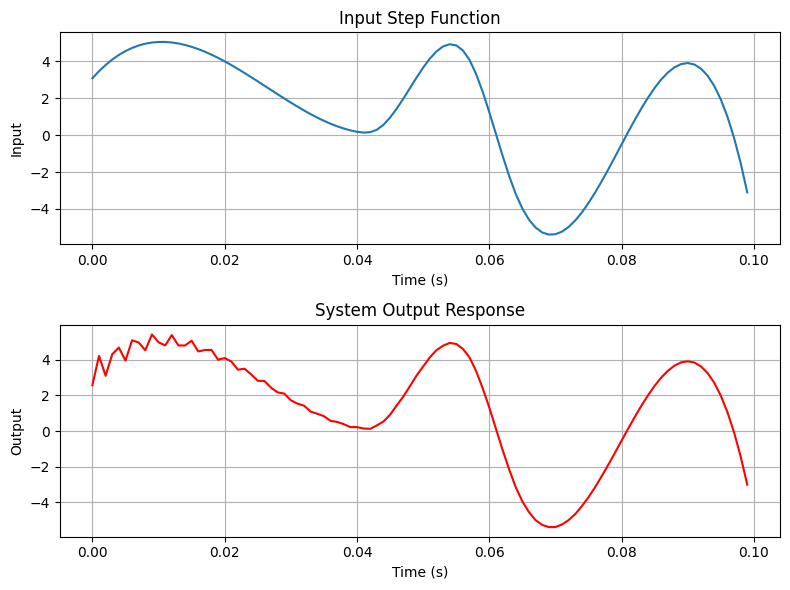

In [11]:
# ---------- input  ----------

time = np.arange(0, 0.1, Ts)

def step_input(time, step_time=0.02, amplitude=1):
    """ generate (Step) input signal """
    input_signal = np.zeros_like(time)
    input_signal[time >= step_time] = amplitude
    return input_signal

def impulse_input(time, impulse_time=0.02, amplitude=1):
    """ generate (Impulse) input signal """
    input_signal = np.zeros_like(time)
    idx = np.where(time >= impulse_time)[0][0]
    input_signal[idx] = amplitude
    return input_signal

def three_stage_ramp(time, t_peak1, t_peak2, slope_up1=1, slope_down=-1, slope_up2=0.5):
    """ generate (Ramp) input signal """
    y = np.piecewise(time,
        [time < t_peak1, 
         (time >= t_peak1) & (time < t_peak2), 
         time >= t_peak2],
        [lambda t: slope_up1 * t,  
         lambda t: slope_down * (t - t_peak1) + slope_up1 * t_peak1,  
         lambda t: slope_up2 * (t - t_peak2) + (slope_down * (t_peak2 - t_peak1) + slope_up1 * t_peak1)]
    )
    return y

def sine_wave_input(time, frequency=5, amplitude=1):
    """ generate (Sine Wave) input signal """
    return amplitude * np.sin(2 * np.pi * frequency * time)

def cubicSpline_input(time):
    num_control_points = np.random.randint(5, 10)  # 隨機取 5~10 個控制點
    control_times = np.sort(np.random.choice(time, num_control_points, replace=False))
    control_values = np.random.uniform(-5, 5, num_control_points)  # 隨機馬達輸入變化
    
    spline = CubicSpline(control_times, control_values)
    return spline(time)

def arbitrary_input(time, max_amplitude = 10, min_amplitude = 0):
    signal = np.zeros_like(time)
    num_impulses = np.random.randint(5, 15)  # 產生 5~15 個隨機脈衝
    impulse_times = np.random.choice(time, num_impulses, replace=False)
    impulse_values = np.random.uniform(min_amplitude, max_amplitude, num_impulses)

    for t, v in zip(impulse_times, impulse_values):
        signal[np.searchsorted(time, t)] = v
    
    return signal

get_input = {
    'step': step_input,
    'impulse': impulse_input,
    'three_stage_ramp': three_stage_ramp,
    'sine': sine_wave_input,
    'cubic': cubicSpline_input,
    'arbitrary': arbitrary_input
}

# input_signal = get_input['step'](time, step_time=0.02, amplitude=10)
# input_signal = get_input['impulse'](time, impulse_time=0, amplitude=1)
# input_signal = get_input['three_stage_ramp'](time, t_peak1=0.02, t_peak2=0.05, slope_up1=300, slope_down=-100, slope_up2=50)
# input_signal = get_input['sine'](time, frequency=10, amplitude=5)
input_signal = get_input['cubic'](time)
# input_signal = get_input['arbitrary'](time, max_amplitude = 10, min_amplitude = 0)

time, response = ctrl.forced_response(G_cl, time, input_signal)

plt.figure(figsize=(8, 6))

# 
plt.subplot(2, 1, 1)
plt.plot(time, input_signal, label="Input (Step Function)")
plt.title("Input Step Function")
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.grid(True)

# 
plt.subplot(2, 1, 2)
plt.plot(time, response, label="Output Response", color='r')
plt.title("System Output Response")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.grid(True)

plt.tight_layout()
plt.show()


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490.]
[ 1.00001560e+00+0.j          1.00000732e+00-0.00345847j
  9.99989387e-01-0.00686991j  9.99982801e-01-0.01018888j
  1.00002330e+00-0.01337346j  1.00016237e+00-0.01638789j
  1.00046827e+00-0.01920646j  1.00102662e+00-0.02181906j
  1.00193943e+00-0.0242391j   1.00332080e+00-0.026514j
  1.00528631e+00-0.02873765j  1.00793210e+00-0.03106196j
  1.01130000e+00-0.03370013j  1.01532937e+00-0.03690834j
  1.01980913e+00-0.04092828j  1.02436348e+00-0.04588207j
  1.02851763e+00-0.05164423j  1.03186352e+00-0.05776256j
  1.03426968e+00-0.06350901j  1.03601662e+00-0.06806545j
  1.03777876e+00-0.07074104j  1.04049276e+00-0.07109773j
  1.04522440e+00-0.06894715j  1.05311712e+00-0.06427036j
  1.06544137e+00-0.05712978j  1.08373316e+00-0.04761492j
  1.11

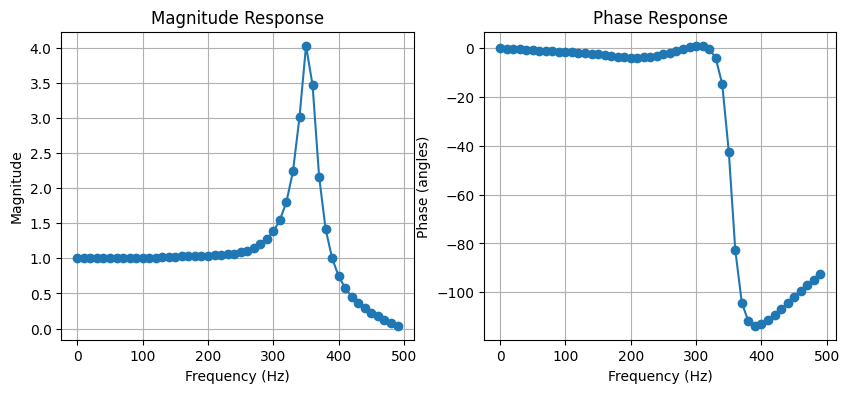

In [15]:
h_n = np.array(response)
H_w = np.fft.fft(h_n)

N = len(h_n)
Ts = 1 / 1000
freqs = np.fft.fftfreq(N, d=Ts)

positive_freqs = freqs[freqs >= 0]
positive_H_w = H_w[freqs >= 0]
print(positive_freqs)
print(positive_H_w)

magnitude_response = np.abs(positive_H_w)
phase_response = np.degrees(np.angle(positive_H_w))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(positive_freqs, magnitude_response, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Response')
plt.grid()

plt.subplot(1,2,2)
plt.plot(positive_freqs, phase_response, marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (angles)')
plt.title('Phase Response')
plt.grid()

plt.show()

In [13]:
data_nums = 1000
data_nums_ramp = 500

output_folder = "dataset"

os.system(f"rm -rf {output_folder}")
os.makedirs(output_folder, exist_ok=True)

for i in range(data_nums):
    # random parameters for each input signal
    step_time = np.random.uniform(0.01, 0.05)
    step_amplitude = np.random.uniform(1, 10)

    freq = np.random.uniform(1, 20)
    sine_amplitude = np.random.uniform(1, 5)

    t_peak1 = np.random.uniform(0.01, 0.03)
    t_peak2 = np.random.uniform(t_peak1 + 0.01, 0.06)
    slope_up1 = np.random.uniform(200, 300)
    slope_down = np.random.uniform(-200, -50)
    slope_up2 = np.random.uniform(50, 300)

    impulse_time = np.random.choice(time)  # 隨機選擇一個時間點產生脈衝
    impulse_amplitude = np.random.uniform(1, 10)

    # step input
    input_signal = get_input['step'](time, step_time=step_time, amplitude=step_amplitude)
    time, response = ctrl.forced_response(G_cl, time, input_signal)
    data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    data.drop('Time', axis=1, inplace=True)
    data.to_csv(f"{output_folder}/filtered_system_data_step_{i}.csv", index=False)

    # Sine input
    input_signal = get_input['sine'](time, frequency=freq, amplitude=sine_amplitude)
    time, response = ctrl.forced_response(G_cl, time, input_signal)
    data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    data.drop('Time', axis=1, inplace=True)
    data.to_csv(f"{output_folder}/filtered_system_data_sine_{i}.csv", index=False)

    # Ramp input
    # input_signal = get_input['three_stage_ramp'](time, t_peak1, t_peak2, slope_up1, slope_down, slope_up2)
    # time, response = ctrl.forced_response(G_cl, time, input_signal)
    # data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    # data.drop('Time', axis=1, inplace=True)
    # data.to_csv(f"{output_folder}/filtered_system_data_three_stage_ramp_{i}.csv", index=False)

    # Impulse input
    input_signal = get_input['impulse'](time, impulse_time=impulse_time, amplitude=impulse_amplitude)
    time, response = ctrl.forced_response(G_cl, time, input_signal)
    data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    data.drop('Time', axis=1, inplace=True)
    data.to_csv(f"{output_folder}/filtered_system_data_impulse_{i}.csv", index=False)

for i in range(data_nums_ramp):
    # random parameters for each input signal
    step_time = np.random.uniform(0.01, 0.05)
    step_amplitude = np.random.uniform(1, 10)

    freq = np.random.uniform(1, 20)
    sine_amplitude = np.random.uniform(1, 5)

    t_peak1 = np.random.uniform(0.01, 0.03)
    t_peak2 = np.random.uniform(t_peak1 + 0.01, 0.06)
    slope_up1 = np.random.uniform(200, 300)
    slope_down = np.random.uniform(-200, -50)
    slope_up2 = np.random.uniform(50, 300)

    impulse_time = np.random.choice(time)  # 隨機選擇一個時間點產生脈衝
    impulse_amplitude = np.random.uniform(1, 10)

    # step input
    # input_signal = get_input['step'](time, step_time=step_time, amplitude=step_amplitude)
    # time, response = ctrl.forced_response(G_cl, time, input_signal)
    # data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    # data.drop('Time', axis=1, inplace=True)
    # data.to_csv(f"{output_folder}/filtered_system_data_step_{i}.csv", index=False)

    # # Sine input
    # input_signal = get_input['sine'](time, frequency=freq, amplitude=sine_amplitude)
    # time, response = ctrl.forced_response(G_cl, time, input_signal)
    # data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    # data.drop('Time', axis=1, inplace=True)
    # data.to_csv(f"{output_folder}/filtered_system_data_sine_{i}.csv", index=False)

    # Ramp input
    input_signal = get_input['three_stage_ramp'](time, t_peak1, t_peak2, slope_up1, slope_down, slope_up2)
    time, response = ctrl.forced_response(G_cl, time, input_signal)
    data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    data.drop('Time', axis=1, inplace=True)
    data.to_csv(f"{output_folder}/filtered_system_data_three_stage_ramp_{i}.csv", index=False)

    # Impulse input
    # input_signal = get_input['impulse'](time, impulse_time=impulse_time, amplitude=impulse_amplitude)
    # time, response = ctrl.forced_response(G_cl, time, input_signal)
    # data = pd.DataFrame({"Time": time, "Input": input_signal, "Output": response})
    # data.drop('Time', axis=1, inplace=True)
    # data.to_csv(f"{output_folder}/filtered_system_data_impulse_{i}.csv", index=False)
